In [2]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
import configparser
import os
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import plotly_express as px
import seaborn as sns; sns.set()
import configparser
config = configparser.ConfigParser()
config.read("../../../env-sample.ini")
data_home = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data'
output_dir = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/output'
local_lib = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/DS5001-2025-01-R/lessons/lib'
import sys
sys.path.append(local_lib)
from textparser import TextParser

clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (5200,   rf"^\s*CHAPTER\s+{roman}\s*$"), #Metamorphosis
    (7849,   rf"^\s*{roman}\s*$"), #The Trial
    (6969,  rf"^\s*LETTER .* to .*$"), # The Castle
    (6262,   rf"^CHAPTER\s+{roman}$"), # Amerika
    (6161,   rf"^CHAPTER\s+\d+$"), # The Judgement
    (6060,   rf"^Chapter\s+\d+$"), # Dearest Father
    (6363,  rf"^Chapter\s+\d+$"), # In the Penal colony
    (6464,   rf"^CHAPTER\s+\d+$"), # The Hunger Artist
    (6565, rf"^\s*CHAPTER\s+{roman}\."), # The Jackals and Arabs
    (6666, rf"^\s*CHAPTER\s+{roman}\s*$"), # A Country Doctor
    (6767, rf"^\s*CHAPTER\s+{roman}\s*$"), # An Imperial Message
    (5959,  rf"^(?:ETYMOLOGY|EXTRACTS|CHAPTER)"), # A report for an Academy
    (5858,  rf"^\s*CHAPTER\s+{roman}\.\s*$"), # The Great Wall of China
    (5757, rf"^\s*{roman}\.\s*$"), # The Hunter Gracchus
    (5656,  rf"^\s*{roman}\. .*$"), # Up in the Gallery
    (5555, rf"^CHAPTER\s+{roman}\.?$"), # Before the Law
    (5454, rf"^\s*[A-Z,;-]+\.\s*$"), # Josephine the Songstress
    (5353,  rf"^CHAPTER "), # The Burrow
    (5252, rf"^CHAPTER\s+{roman}\.\s*$"), # Blumfeld
    (23532, rf"Chapter\s+{roman}") # Meditation
]
chapter_regexes = [
    (5200,   rf"^\s*{roman}\s*$"),
    (7849,   rf"^\s*Chapter\s+(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten)\s*$"),
    (6969,   rf"^\s*\d+\s*$"),
    (6262,   rf"^\s*\d+\s*$"),
    (6161,   "NOCHAPTERS"),
    (6060,   "NOCHAPTERS"),
    (6363,   "NOCHAPTERS"),
    (6464,   "NOCHAPTERS"),
    (6565,   "NOCHAPTERS"),
    (6666,   "NOCHAPTERS"),
    (6767,   "NOCHAPTERS"),
    (5959,   "NOCHAPTERS"),
    (5858,   "NOCHAPTERS"),
    (5757,   "NOCHAPTERS"),
    (5656,   "NOCHAPTERS"),
    (5555,   "NOCHAPTERS"),
    (5454,   "NOCHAPTERS"),
    (5353,   "NOCHAPTERS"),
    (5252,   "NOCHAPTERS"),
    (23532,  rf"^(Children on the country road|Unmasking a con artist|The Sudden Walk|Resolutions|The trip to the mountains|The Bachelor's Misfortune|The Merchant|Distracted Looking Out|The Way Home|The Passers-by|Passenger|Dresses|The rejection|Food for thought for gentlemen riders|The Alley Window|Desire to become an Indian|The Trees|Unhappiness)$")  # Poem title on line 1
]
ohco_pat_list = chapter_regexes
source_files = f'{data_home}'
source_file_list = sorted(glob(f"{source_files}/*.*"))

book_data = []
for source_file_path in source_file_list:
    # Get the filename only, e.g. 'pg5353.txt'
    filename = os.path.basename(source_file_path)
    # Extract the numeric ID from the filename (remove 'pg' and '.txt')
    book_id = int(filename.replace('pg', '').replace('.txt', ''))
    # Use filename (without extension) as a raw title (optional: clean further)
    book_title = filename.replace('.txt', '').replace('_', ' ')
    # Append a tuple of (book_id, path, title)
    book_data.append((book_id, source_file_path, book_title))
# Convert to DataFrame
LIB = pd.DataFrame(book_data, columns=['book_id', 'source_file_path', 'raw_title']) \
        .set_index('book_id') \
        .sort_index()
book_titles = {
    5200: "Metamorphosis",
    7849: "The Trial",
    6969: "The Castle",
    6262: "Amerika",
    6161: "The Judgement",
    6060: "Dearest Father",
    6363: "In the Penal Colony",
    6464: "The Hunger Artist",
    6565: "The Jackals and Arabs",
    6666: "A Country Doctor",
    6767: "An Imperial Message",
    5959: "A Report for an Academy",
    5858: "The Great Wall of China",
    5757: "The Hunter Gracchus",
    5656: "Up in the Gallery",
    5555: "Before the Law",
    5454: "Josephine the Songstress",
    5353: "The Burrow",
    5252: "Blumfeld",
    23532: "Meditation"
}
book_titles = {f'pg{key}': value for key, value in book_titles.items()}
try:
    LIB['author'] = 'KAFKA, FRANZ'
    LIB['title'] = LIB.raw_title.replace(book_titles).str.upper()
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))
LIB
# This cell takes 16 seconds to run
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)
        # text = TextImporter(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats) 

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS
CORPUS = tokenize_collection(LIB)

CORPUS = CORPUS[CORPUS.term_str != '']
CORPUS['pos_group'] = CORPUS.pos.str[:2]
CORPUS
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

VOCAB
# Functions to create TFIDF:
# Bring into your notebook the functions you created previously to generate a BOW table and compute TFIDF values. 
# Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.
def gather_docs(CORPUS, ohco_level, term_col='term_str'):
    OHCO = CORPUS.index.names
    CORPUS[term_col] = CORPUS[term_col].astype('str')
    DOC = CORPUS.groupby(OHCO[:ohco_level])[term_col].apply(lambda x:' '.join(x)).to_frame('doc_str')
    return DOC

def BOW(tokendf, ocholevel):
    return tokendf.groupby(bags[ocholevel]+['term_str']).term_str.count().to_frame('n') 

def BOWtoTFIDF(BOW, tf_method, CORPUS, ocholevel = 2):
    
    # I added another parameter for the CORPUS because otherwise it becomes really tedious to undo the BOW function

    DTCM = BOW.n.unstack(fill_value=0)
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    IDF = IDF = np.log2(N / DF)
    TFIDF = TF * IDF
    # Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.

    # We can adjust ocho level here if we want to, default is 2
    DOC = gather_docs(CORPUS, 2)
    DOC['n_tokens'] = DOC.doc_str.apply(lambda x: len(x.split()))
    ngram_range = (1,2)
    n_terms = 4000
    count_engine = CountVectorizer(
        stop_words = 'english',
        ngram_range = ngram_range,
        max_features = n_terms)
    X = count_engine.fit_transform(DOC.doc_str)
    DTM = pd.DataFrame(X.toarray(), 
    columns=count_engine.get_feature_names_out(), 
    index=DOC.index)
    VOCAB = DTM.sum().to_frame('n')
    VOCAB.index.name = 'term_str'
    VOCAB['df'] = DTM.astype(bool).sum()
    VOCAB['dfidf'] = VOCAB.df * np.log2(len(DTM)/VOCAB.df)
    VOCAB['dp'] = VOCAB.df / len(DTM)
    VOCAB['di'] = np.log2(1/VOCAB.dp)
    VOCAB['dh'] = VOCAB.dp * VOCAB.di
    VOCAB['n_chars'] = VOCAB.apply(lambda x: len(x.name), 1)
    VOCAB['n_tokens'] = VOCAB.apply(lambda x: len(x.name.split()), 1)
    VOCAB.sort_index()


    #Hopefully this join works but I'm actually not too sure this will work
    
    return TFIDF,VOCAB,DTM

# I think I'm going to use this oneliner more.
# get_tfidf = lambda X, agg_func='sum': (X.T / X.T.agg(agg_func)).T * (np.log2(len(X)/X.astype('bool').sum()))
OHCO = ['book_id','chap_id', 'para_num', 'sent_num', 'token_num']

bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)
tables = BOWtoTFIDF(BOW(CORPUS,'CHAPS'),'max', CORPUS, 2)
DTM = tables[2]
DFIDF = tables[1]
TFIDF = tables[0]

Tokenizing 5200 METAMORPHOSIS
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5200.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[IVXLCM]+\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5252 BLUMFELD
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5252.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5353 THE BURROW
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5353.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
li

c:\Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/DS5001-2025-01-R/lessons/lib\textparser.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Done


## BOW

In [3]:
bow_df= BOW(CORPUS,'CHAPS')

In [4]:
TFIDF.T.columns

MultiIndex([( 5200,  1),
            ( 5200,  2),
            ( 5200,  3),
            ( 5252,  1),
            ( 5353,  1),
            ( 5454,  1),
            ( 5454,  2),
            ( 5555,  1),
            ( 5656,  1),
            ( 5757,  1),
            ( 5858,  1),
            ( 5959,  1),
            ( 6060,  1),
            ( 6161,  1),
            ( 6262,  1),
            ( 6262,  2),
            ( 6262,  3),
            ( 6262,  4),
            ( 6262,  5),
            ( 6262,  6),
            ( 6363,  1),
            ( 6464,  1),
            ( 6565,  1),
            ( 6666,  1),
            ( 6767,  1),
            ( 6969,  1),
            ( 6969,  2),
            ( 6969,  3),
            ( 6969,  4),
            ( 6969,  5),
            ( 6969,  6),
            ( 6969,  7),
            ( 6969,  8),
            ( 6969,  9),
            ( 6969, 10),
            ( 6969, 11),
            ( 6969, 12),
            ( 6969, 13),
            ( 6969, 14),
            ( 6969, 15),


In [5]:
# Step 1: Reset index so book_id and chap_id become columns
tfidf_reset = TFIDF.reset_index()

# Step 2: Melt all term columns into a long format
tfidf_long = tfidf_reset.melt(
    id_vars=['book_id', 'chap_id'],
    var_name='term_str',
    value_name='tfidf'
)

# Step 3: Merge with bag-of-words dataframe
bow_with_tfidf = bow_df.merge(
    tfidf_long,
    on=['book_id', 'chap_id', 'term_str'],
    how='left'
)

### BOW

In [6]:
#bow_with_tfidf.to_csv('BOW.csv')

In [7]:
bow_with_tfidf

,book_id,chap_id,term_str,n,tfidf
0,5200,1,a,108,0.000000
1,5200,1,abandoning,1,0.009230
2,5200,1,able,7,0.005868
3,5200,1,about,16,0.008273
4,5200,1,above,2,0.003155
...,...,...,...,...,...
80544,23532,10,you,55,0.068376
80545,23532,10,your,7,0.024125
80546,23532,10,youre,8,0.078501
80547,23532,10,yourself,2,0.018776


## DTM

In [8]:
DTM

term_str         abandoned  abandoning  abilities  ability  able  able make  \
book_id chap_id                                                               
5200    1                0           1          0        0     7          0   
        2                1           1          0        1    13          0   
        3                1           0          0        0     3          0   
5252    1                1           1          0        0     4          0   
5353    1                0           0          1        1     5          0   
...                    ...         ...        ...      ...   ...        ...   
23532   6                0           0          0        0     0          0   
        7                0           0          0        0     0          0   
        8                0           0          0        0     1          0   
        9                0           0          0        0     1          0   
        10               1           0          0        0     1          0   

term_str         abruptly  absence  absent  absolute  ...  ﬁre  ﬁre brigade  \
book_id chap_id                                       ...                     
5200    1               0        0       0         0  ...    0            0   
        2               0        0       0         0  ...    0            0   
        3               1        0       0         0  ...    0            0   
5252    1               0        1       0         0  ...    0            0   
5353    1               0        6       0         0  ...    0            0   
...                   ...      ...     ...       ...  ...  ...          ...   
23532   6               0        0       0         0  ...    0            0   
        7               0        0       0         0  ...    0            0   
        8               0        0       0         0  ...    0            0   
        9               0        0       0         0  ...    0            0   
        10              0        0       0         0  ...    0            0   

term_str         ﬁre engine  ﬁrmly  ﬁrst  ﬁrst time  ﬁst  ﬁt  ﬁxed  ﬂoor  
book_id chap_id                                                           
5200    1                 0      0     0          0    0   0     0     0  
        2                 0      0     0          0    0   0     0     0  
        3                 0      0     0          0    0   0     0     0  
5252    1                 0      0     0          0    0   0     0     0  
5353    1                 0      0     0          0    0   0     0     0  
...                     ...    ...   ...        ...  ...  ..   ...   ...  
23532   6                 0      0     0          0    0   0     0     0  
        7                 0      0     0          0    0   0     0     0  
        8                 0      0     0          0    0   0     0     0  
        9                 0      0     0          0    0   0     0     0  
        10                0      0     0          0    0   0     0     0  

[70 rows x 4000 columns]

In [9]:
#DTM.to_csv('DTM.csv')

## TFIDF

In [10]:
TFIDF

term_str           1   10   15    2   25    3  430  536    6    a  ...  ﬂoors  \
book_id chap_id                                                    ...          
5200    1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5252    1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5353    1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
23532   6        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        7        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        8        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        9        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        10       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

term_str         ﬂopped  ﬂowered  ﬂowers  ﬂown  ﬂung  ﬂushed  ﬂuttered  \
book_id chap_id                                                          
5200    1           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        2           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        3           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
5252    1           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
5353    1           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
...                 ...      ...     ...   ...   ...     ...       ...   
23532   6           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        7           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        8           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        9           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        10          0.0      0.0     0.0   0.0   0.0     0.0       0.0   

term_str         ﬂuttering  ﬂying  
book_id chap_id                    
5200    1              0.0    0.0  
        2              0.0    0.0  
        3              0.0    0.0  
5252    1              0.0    0.0  
5353    1              0.0    0.0  
...                    ...    ...  
23532   6              0.0    0.0  
        7              0.0    0.0  
        8              0.0    0.0  
        9              0.0    0.0  
        10             0.0    0.0  

[70 rows x 14598 columns]

In [11]:
#TFIDF.to_csv('TFIDF.csv')

## Reduced and Normalized TFIDF_L2

In [12]:
tfidf_engine = TfidfTransformer(norm='l2', use_idf=True)
X1 = tfidf_engine.fit_transform(DTM)
L2 = pd.DataFrame(X1.toarray(), columns=DTM.columns, index=DTM.index)
L2

term_str         abandoned  abandoning  abilities  ability      able  \
book_id chap_id                                                        
5200    1         0.000000    0.008635   0.000000  0.00000  0.022226   
        2         0.005631    0.007872   0.000000  0.00680  0.037633   
        3         0.005539    0.000000   0.000000  0.00000  0.008543   
5252    1         0.003160    0.004418   0.000000  0.00000  0.006498   
5353    1         0.000000    0.000000   0.004867  0.00438  0.009324   
...                    ...         ...        ...      ...       ...   
23532   6         0.000000    0.000000   0.000000  0.00000  0.000000   
        7         0.000000    0.000000   0.000000  0.00000  0.000000   
        8         0.000000    0.000000   0.000000  0.00000  0.047635   
        9         0.000000    0.000000   0.000000  0.00000  0.091053   
        10        0.035651    0.000000   0.000000  0.00000  0.018329   

term_str         able make  abruptly   absence  absent  absolute  ...  ﬁre  \
book_id chap_id                                                   ...        
5200    1              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        2              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        3              0.0  0.007158  0.000000     0.0       0.0  ...  0.0   
5252    1              0.0  0.000000  0.003593     0.0       0.0  ...  0.0   
5353    1              0.0  0.000000  0.024749     0.0       0.0  ...  0.0   
...                    ...       ...       ...     ...       ...  ...  ...   
23532   6              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        7              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        8              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        9              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        10             0.0  0.000000  0.000000     0.0       0.0  ...  0.0   

term_str         ﬁre brigade  ﬁre engine  ﬁrmly  ﬁrst  ﬁrst time  ﬁst   ﬁt  \
book_id chap_id                                                              
5200    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        2                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        3                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
5252    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
5353    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
...                      ...         ...    ...   ...        ...  ...  ...   
23532   6                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        7                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        8                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        9                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        10               0.0         0.0    0.0   0.0        0.0  0.0  0.0   

term_str         ﬁxed  ﬂoor  
book_id chap_id              
5200    1         0.0   0.0  
        2         0.0   0.0  
        3         0.0   0.0  
5252    1         0.0   0.0  
5353    1         0.0   0.0  
...               ...   ...  
23532   6         0.0   0.0  
        7         0.0   0.0  
        8         0.0   0.0  
        9         0.0   0.0  
        10        0.0   0.0  

[70 rows x 4000 columns]

In [13]:
#L2.to_csv('L2.csv')

# PCA

In [14]:
LIB['work_type'] = LIB['title'].str.lower()
replacemap = {
    "amerika": "novel",
    "the castle": "novel",
    "the trial": "novel",
    
    "metamorphosis": "novella",
    "the burrow": "novella",
    "in the penal colony": "novella",
    "the hunger artist": "novella",
    
    "blumfeld": "short story",
    "josephine the songstress": "short story",
    "before the law": "short story",
    "up in the gallery": "short story",
    "the hunter gracchus": "short story",
    "the great wall of china": "short story",
    "a report for an academy": "short story",
    "the judgement": "short story",
    "the jackals and arabs": "short story",
    "a country doctor": "short story",
    "an imperial message": "short story",
    "meditation": "short story",
    
    "dearest father": "letter"
}
LIB['work_type'] = LIB['work_type'].replace(replacemap)
LIB

kafka_named_character_map = {
    "amerika": "named",
    "the castle": "unnamed",
    "the trial": "named",

    "metamorphosis": "named",
    "the burrow": "unnamed",
    "in the penal colony": "unnamed",
    "the hunger artist": "unnamed",

    "blumfeld": "named",
    "josephine the songstress": "named",
    "before the law": "unnamed",
    "up in the gallery": "unnamed",
    "the hunter gracchus": "named",
    "the great wall of china": "unnamed",
    "a report for an academy": "unnamed",
    "the judgement": "named",
    "the jackals and arabs": "unnamed",
    "a country doctor": "unnamed",
    "an imperial message": "unnamed",
    "meditation": "unnamed",

    "dearest father": "named"
}
LIB['protagonist_name'] = LIB['title'].str.lower()
LIB['protagonist_name'] = LIB['protagonist_name'].replace(kafka_named_character_map)
LIB['ending_type'] = LIB['title'].str.lower()

kafka_ending_map = {
    "amerika": "ambiguous",
    "the castle": "not happy",
    "the trial": "not happy",

    "metamorphosis": "not happy",
    "the burrow": "not happy",
    "in the penal colony": "not happy",
    "the hunger artist": "not happy",

    "blumfeld": "ambiguous",
    "josephine the songstress": "not happy",
    "before the law": "not happy",
    "up in the gallery": "ambiguous",
    "the hunter gracchus": "not happy",
    "the great wall of china": "ambiguous",
    "a report for an academy": "ambiguous",
    "the judgement": "not happy",
    "the jackals and arabs": "not happy",
    "a country doctor": "not happy",
    "an imperial message": "not happy",
    "meditation": "ambiguous",

    "dearest father": "not happy"
}
LIB['ending_type'] = LIB['ending_type'].replace(kafka_ending_map)
LIB

,source_file_path,author,title,chap_regex,work_type,protagonist_name,ending_type
book_id,,,,,,,
5200,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",METAMORPHOSIS,^\s*[IVXLCM]+\s*$,novella,named,not happy
5252,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BLUMFELD,NOCHAPTERS,short story,named,ambiguous
5353,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE BURROW,NOCHAPTERS,novella,unnamed,not happy
5454,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",JOSEPHINE THE SONGSTRESS,NOCHAPTERS,short story,named,not happy
5555,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BEFORE THE LAW,NOCHAPTERS,short story,unnamed,not happy
5656,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",UP IN THE GALLERY,NOCHAPTERS,short story,unnamed,ambiguous
5757,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE HUNTER GRACCHUS,NOCHAPTERS,short story,named,not happy
5858,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE GREAT WALL OF CHINA,NOCHAPTERS,short story,unnamed,ambiguous
5959,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",A REPORT FOR AN ACADEMY,NOCHAPTERS,short story,unnamed,ambiguous


In [15]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','work_type']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='work_type', hover_name= 'work_type')

In [16]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','protagonist_name']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='protagonist_name', hover_name= 'protagonist_name')

In [17]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','ending_type']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='ending_type', hover_name= 'ending_type')

In [18]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','title']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='title', hover_name= 'title')

In [19]:
vis_pcs(DCM, 2, 3, label='title', hover_name= 'title')

## PCA COMPONENTS

In [20]:
LOADINGS['PC0'].sort_values(ascending=False).head(10)

term_str
karl            0.110122
uncle           0.021376
delamarche      0.018304
didn            0.018258
gregor          0.017931
pollunder       0.017896
said karl       0.017217
mr pollunder    0.016251
robinson        0.015656
stoker          0.014562
Name: PC0, dtype: float64

In [21]:
LOADINGS['PC1'].sort_values(ascending=True).head(10)

term_str
gregor       -0.034116
horse        -0.018078
gregors      -0.016463
sister       -0.014837
father       -0.012864
folk         -0.011750
horses       -0.011276
josephine    -0.010956
gatekeeper   -0.010298
beautiful    -0.008728
Name: PC1, dtype: float64

In [22]:
COMPONENTS = pd.DataFrame(pca_engine.components_)
COMPONENTS
#COMPONENTS.to_csv('COMPONENTS.csv')

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.002507,-0.001024,-0.000975,0.003987,0.009780,-0.001868,0.000412,-0.000389,0.001705,0.001553,...,-0.027268,-0.011083,-0.009204,-0.012081,-0.089775,-0.006934,-0.008719,-0.007636,-0.009840,-0.023940
1,-0.001553,-0.000126,-0.000813,-0.008354,-0.010342,0.001326,0.002178,0.003725,0.000437,-0.001019,...,0.001634,-0.000962,0.000730,0.004946,0.036727,0.002789,0.004695,0.002373,0.004467,0.012631
2,-0.005395,0.001968,0.004241,-0.003790,-0.004026,0.002714,-0.001159,0.008280,0.000904,-0.002187,...,0.080304,0.044472,0.030097,0.004942,0.053432,0.003054,-0.003737,0.004385,0.005125,-0.010317
3,0.005249,0.004777,-0.000228,-0.009001,-0.001847,0.001084,0.003536,0.000791,0.001773,0.000304,...,-0.003772,-0.002191,-0.003713,0.000660,-0.007953,0.000500,0.000409,0.000685,-0.000016,0.002475
4,-0.007298,0.003474,-0.001495,0.006230,0.004646,-0.009339,-0.000608,0.001445,0.000013,-0.007620,...,0.005923,0.000993,0.004106,0.004094,0.024832,0.001765,0.005651,-0.000189,0.002207,0.014926
5,-0.003491,0.000288,0.001203,0.035722,0.051112,-0.001909,0.002138,0.001883,0.001330,0.010936,...,-0.001053,-0.000963,-0.002133,0.001282,-0.003727,0.000391,0.000727,-0.001460,-0.001835,-0.000691
6,-0.001498,0.000045,-0.007628,0.007079,0.021341,0.003273,0.002265,-0.007918,-0.006478,-0.000486,...,-0.097055,-0.047477,-0.035746,-0.011246,-0.016292,-0.007805,-0.005060,-0.004890,-0.007995,-0.028458
7,-0.007402,0.005620,-0.005634,0.000911,0.010043,0.000055,-0.003414,-0.008760,0.004223,-0.000069,...,-0.026278,-0.014802,-0.008007,-0.007311,-0.011404,-0.004357,-0.000937,-0.006030,0.001647,0.003689
8,0.006461,-0.000870,-0.002668,0.014845,0.060301,0.002963,-0.002269,-0.005491,-0.002485,0.004897,...,0.038401,0.018513,0.016183,0.002900,-0.003211,-0.000724,0.003692,0.003469,-0.001931,0.010432
9,-0.010991,-0.003658,-0.002504,-0.013368,-0.014816,-0.004657,0.007013,0.007072,0.009913,0.001286,...,0.061303,0.034649,0.027626,0.004743,0.022945,0.004369,-0.004269,0.000604,-0.000662,-0.008873


In [23]:
DCM
#DCM.to_csv('DCM.csv')

PC0       PC1       PC2       PC3       PC4       PC5  \
book_id chap_id                                                               
5200    1        0.141240 -0.255678  0.097355  0.675868  0.196403  0.022742   
        2        0.176964 -0.282374  0.128947  0.733356  0.285086  0.017066   
        3        0.168475 -0.257087  0.104607  0.685240  0.247722  0.010146   
5252    1        0.135159 -0.137361 -0.026505 -0.113844  0.103404  0.010358   
5353    1        0.099947 -0.138921  0.068704 -0.100047  0.057810  0.102188   
...                   ...       ...       ...       ...       ...       ...   
23532   6        0.167892 -0.177268 -0.016588 -0.181806  0.183515 -0.102065   
        7        0.166838 -0.176128 -0.033129 -0.171840  0.137960 -0.102293   
        8        0.180928 -0.216571 -0.037847 -0.197959  0.146614 -0.209644   
        9        0.189041 -0.205995 -0.060473 -0.205022  0.212065 -0.294701   
        10       0.008177 -0.077656 -0.130454  0.056826 -0.170220 -0.021596   

                      PC6       PC7       PC8       PC9        author  \
book_id chap_id                                                         
5200    1        0.136298  0.030173  0.028605 -0.075081  KAFKA, FRANZ   
        2        0.113509  0.032126  0.009983 -0.056842  KAFKA, FRANZ   
        3        0.101235  0.039760  0.012666 -0.013978  KAFKA, FRANZ   
5252    1       -0.021493  0.072386 -0.169167  0.028978  KAFKA, FRANZ   
5353    1       -0.017169 -0.184517 -0.197913 -0.089956  KAFKA, FRANZ   
...                   ...       ...       ...       ...           ...   
23532   6       -0.061899  0.001253 -0.240681  0.187236  KAFKA, FRANZ   
        7       -0.040175  0.006167 -0.154802  0.187498  KAFKA, FRANZ   
        8        0.056692  0.073709  0.269002  0.030936  KAFKA, FRANZ   
        9        0.147293  0.116967  0.403336  0.134091  KAFKA, FRANZ   
        10      -0.038652 -0.063233  0.047123 -0.153061  KAFKA, FRANZ   

                         title  
book_id chap_id                 
5200    1        METAMORPHOSIS  
        2        METAMORPHOSIS  
        3        METAMORPHOSIS  
5252    1             BLUMFELD  
5353    1           THE BURROW  
...                        ...  
23532   6           MEDITATION  
        7           MEDITATION  
        8           MEDITATION  
        9           MEDITATION  
        10          MEDITATION  

[70 rows x 12 columns]

In [24]:
LOADINGS
#LOADINGS.to_csv('LOADINGS.csv')

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,porter_stem,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,,,,,,,,
abandoned,0.000617,-0.000331,-0.000971,0.000918,-0.001206,-0.000516,-0.000210,-0.001021,0.000872,-0.001465,...,VBN,VB,4.0,"{RP, NN, JJ, VB}",5.0,"{NN, VBN, VBD, JJ, RP}",0.0,abandon,abandon,abandon
abandoning,-0.000252,-0.000027,0.000354,0.000835,0.000574,0.000043,0.000006,0.000776,-0.000117,-0.000488,...,VBG,VB,1.0,{VB},1.0,{VBG},0.0,abandon,abandon,abandon
abilities,-0.000240,-0.000174,0.000763,-0.000040,-0.000247,0.000178,-0.001070,-0.000777,-0.000360,-0.000334,...,NNS,NN,1.0,{NN},2.0,"{NNS, NN}",0.0,abil,abil,abl
ability,0.000981,-0.001783,-0.000682,-0.001574,0.001030,0.005278,0.000993,0.000126,0.002005,-0.001782,...,NN,NN,1.0,{NN},1.0,{NN},0.0,abil,abil,abl
able,0.002406,-0.002207,-0.000724,-0.000323,0.000768,0.007552,0.002994,0.001386,0.008143,-0.001975,...,JJ,JJ,4.0,"{RB, NN, JJ, VB}",5.0,"{RB, VBP, NN, VBN, JJ}",0.0,abl,abl,abl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ﬁrst time,-0.001706,0.000595,0.000550,0.000087,0.000292,0.000058,-0.001095,-0.000601,-0.000098,0.000583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ﬁst,-0.002145,0.001002,-0.000672,0.000071,0.000934,0.000107,-0.000710,-0.000129,0.000499,-0.000569,...,NN,NN,2.0,"{NN, FW}",2.0,"{NN, FW}",0.0,ﬁst,ﬁst,ﬁst
ﬁt,-0.001879,0.000506,0.000789,0.000120,-0.000031,-0.000216,-0.000686,-0.000832,0.000468,0.000080,...,NN,NN,4.0,"{NN, JJ, VB, CD}",6.0,"{NNS, VB, CD, VBP, NN, JJ}",0.0,ﬁt,ﬁt,ﬁt


In [25]:
import plotly.express as px

fig = px.scatter(
    LOADINGS.reset_index(),  # reset index so 'term_str' becomes a column
    x="PC0",
    y="PC1",
    hover_name="term_str",   # so you can hover over points and see the term
    height=800
)
fig.show()

In [26]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','protagonist_name']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 3, 2, label='protagonist_name', hover_name= 'protagonist_name')


In [27]:
LIB

,source_file_path,author,title,chap_regex,work_type,protagonist_name,ending_type
book_id,,,,,,,
5200,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",METAMORPHOSIS,^\s*[IVXLCM]+\s*$,novella,named,not happy
5252,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BLUMFELD,NOCHAPTERS,short story,named,ambiguous
5353,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE BURROW,NOCHAPTERS,novella,unnamed,not happy
5454,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",JOSEPHINE THE SONGSTRESS,NOCHAPTERS,short story,named,not happy
5555,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BEFORE THE LAW,NOCHAPTERS,short story,unnamed,not happy
5656,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",UP IN THE GALLERY,NOCHAPTERS,short story,unnamed,ambiguous
5757,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE HUNTER GRACCHUS,NOCHAPTERS,short story,named,not happy
5858,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE GREAT WALL OF CHINA,NOCHAPTERS,short story,unnamed,ambiguous
5959,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",A REPORT FOR AN ACADEMY,NOCHAPTERS,short story,unnamed,ambiguous


In [28]:
import plotly.express as px

fig = px.scatter(
    LOADINGS.reset_index(),  # reset index so 'term_str' becomes a column
    x="PC3",
    y="PC2",
    hover_name="term_str",   # so you can hover over points and see the term
    height=800
)
fig.show()

### LDA

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
OHCO = ['book_id', 'chap_id', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]
BAG = CHAP


ngram_range = (1, 2)
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 9


import warnings
warnings.filterwarnings('ignore')
TOKENS = CORPUS.reset_index()
TOKENS
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
DTM

# This cell takes 11.3 seconds to run
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
lda_model = lda_engine.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES
THETA

THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

### LDA PHI

In [30]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rugs,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,6.025000,0.025000,0.025000,0.025000
candle,0.025000,0.025000,0.025000,0.025000,3.798626,0.025000,0.025000,0.025000,0.025000,0.025000,1.201326,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,22.302359,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,6.778652,0.025000,3.838212,14.904162,0.025000,0.025000,1.001254,0.025000,1.375408,0.025000
joke,0.025000,0.025000,1.026816,0.025000,8.928708,1.033604,0.025000,0.025000,0.025000,1.016595,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,1.025000,3.046361,0.025000,1.030145,0.025000,2.112982,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.143945,1.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,5.885843,0.025000
disgust,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.028538,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.585505,0.025000,0.025000,0.025000,2.286869,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.199088,0.025000
studio,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,10.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
time question,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000
smoke,1.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.030952,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.331255,0.025000,0.025000,0.025000,1.038201,1.260522,0.025000,0.025000,0.025000,4.395131,0.025000,0.025000,0.025000,4.093939,0.025000,0.025000,1.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000
liquid,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025282,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.368168,0.025000,0.025000,0.025000,5.681550,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
beating,0.025000,0.025000,0.025000,0.025000,4.508308,1.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.541692,0.025000


In [31]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T38,assistants time landlady room way teacher man bar people,10.883749,0.112011
T04,room way door time sister things hand course life,5.624936,0.117394
T30,man time way suitcase hand hands people head eyes,5.518326,0.071388
T22,room door way time letter servant clerk table hand,5.479734,0.060742
T10,way woman people man judge time hand court room,3.738960,0.040320
T08,mother father room time lift boy friend door way,3.358673,0.051268
T21,gentleman ﬁles landlady servant way door gentlemen landlord corridor,2.944634,0.026123
T01,castle man landlord land public way surveyor land surveyor inn,2.634840,0.034395
T05,stoker man captain gentlemen way time ship door hand,2.524714,0.039747


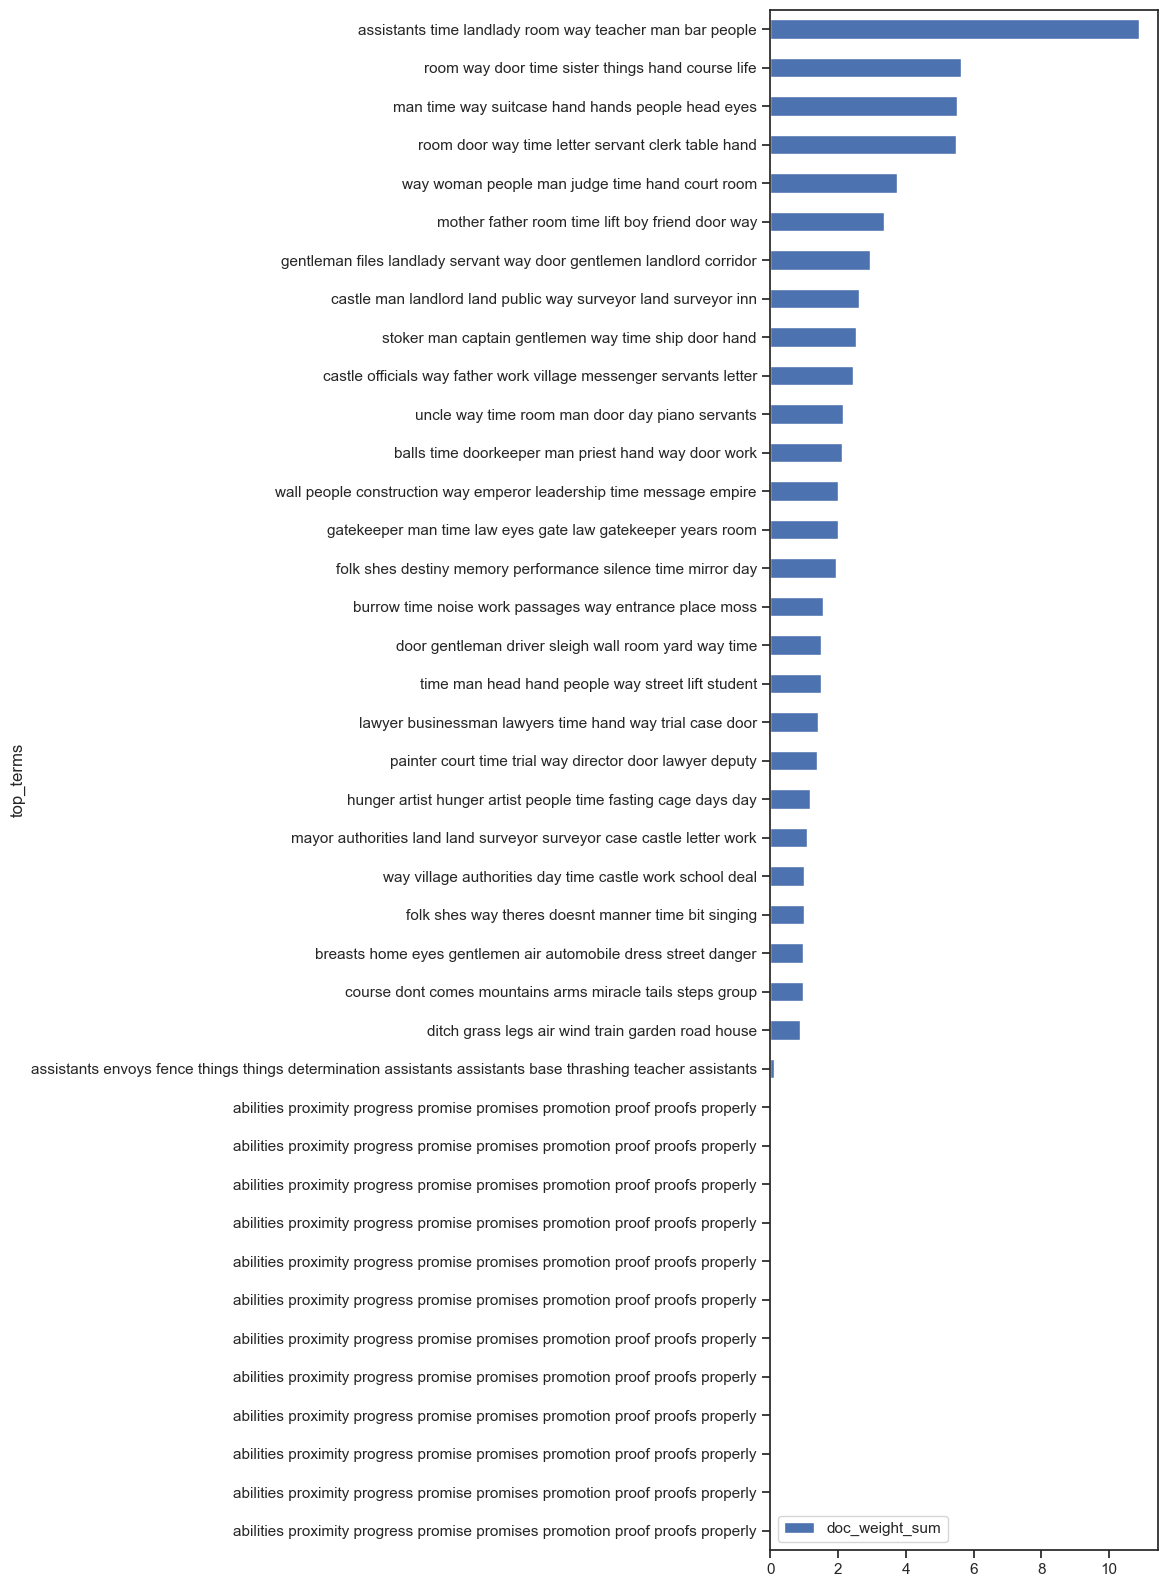

In [32]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));

<Axes: ylabel='top_terms'>

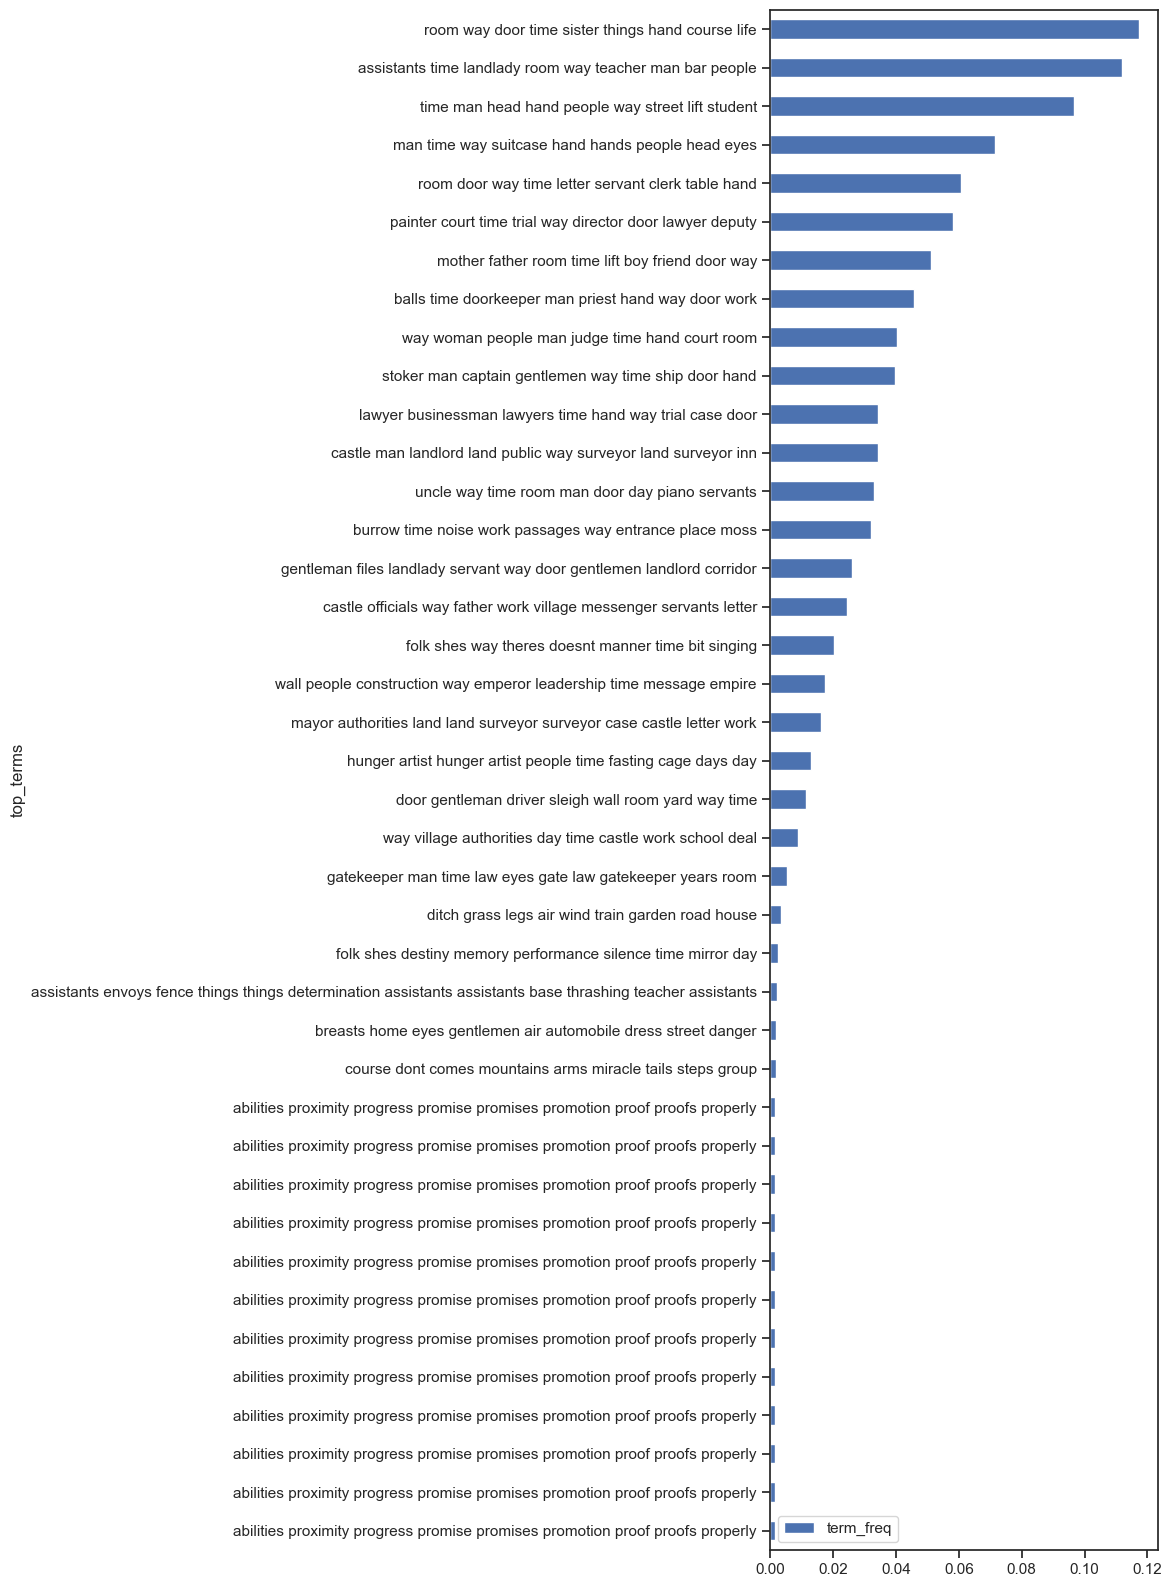

In [33]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='top_terms', figsize=(5, n_topics/2))

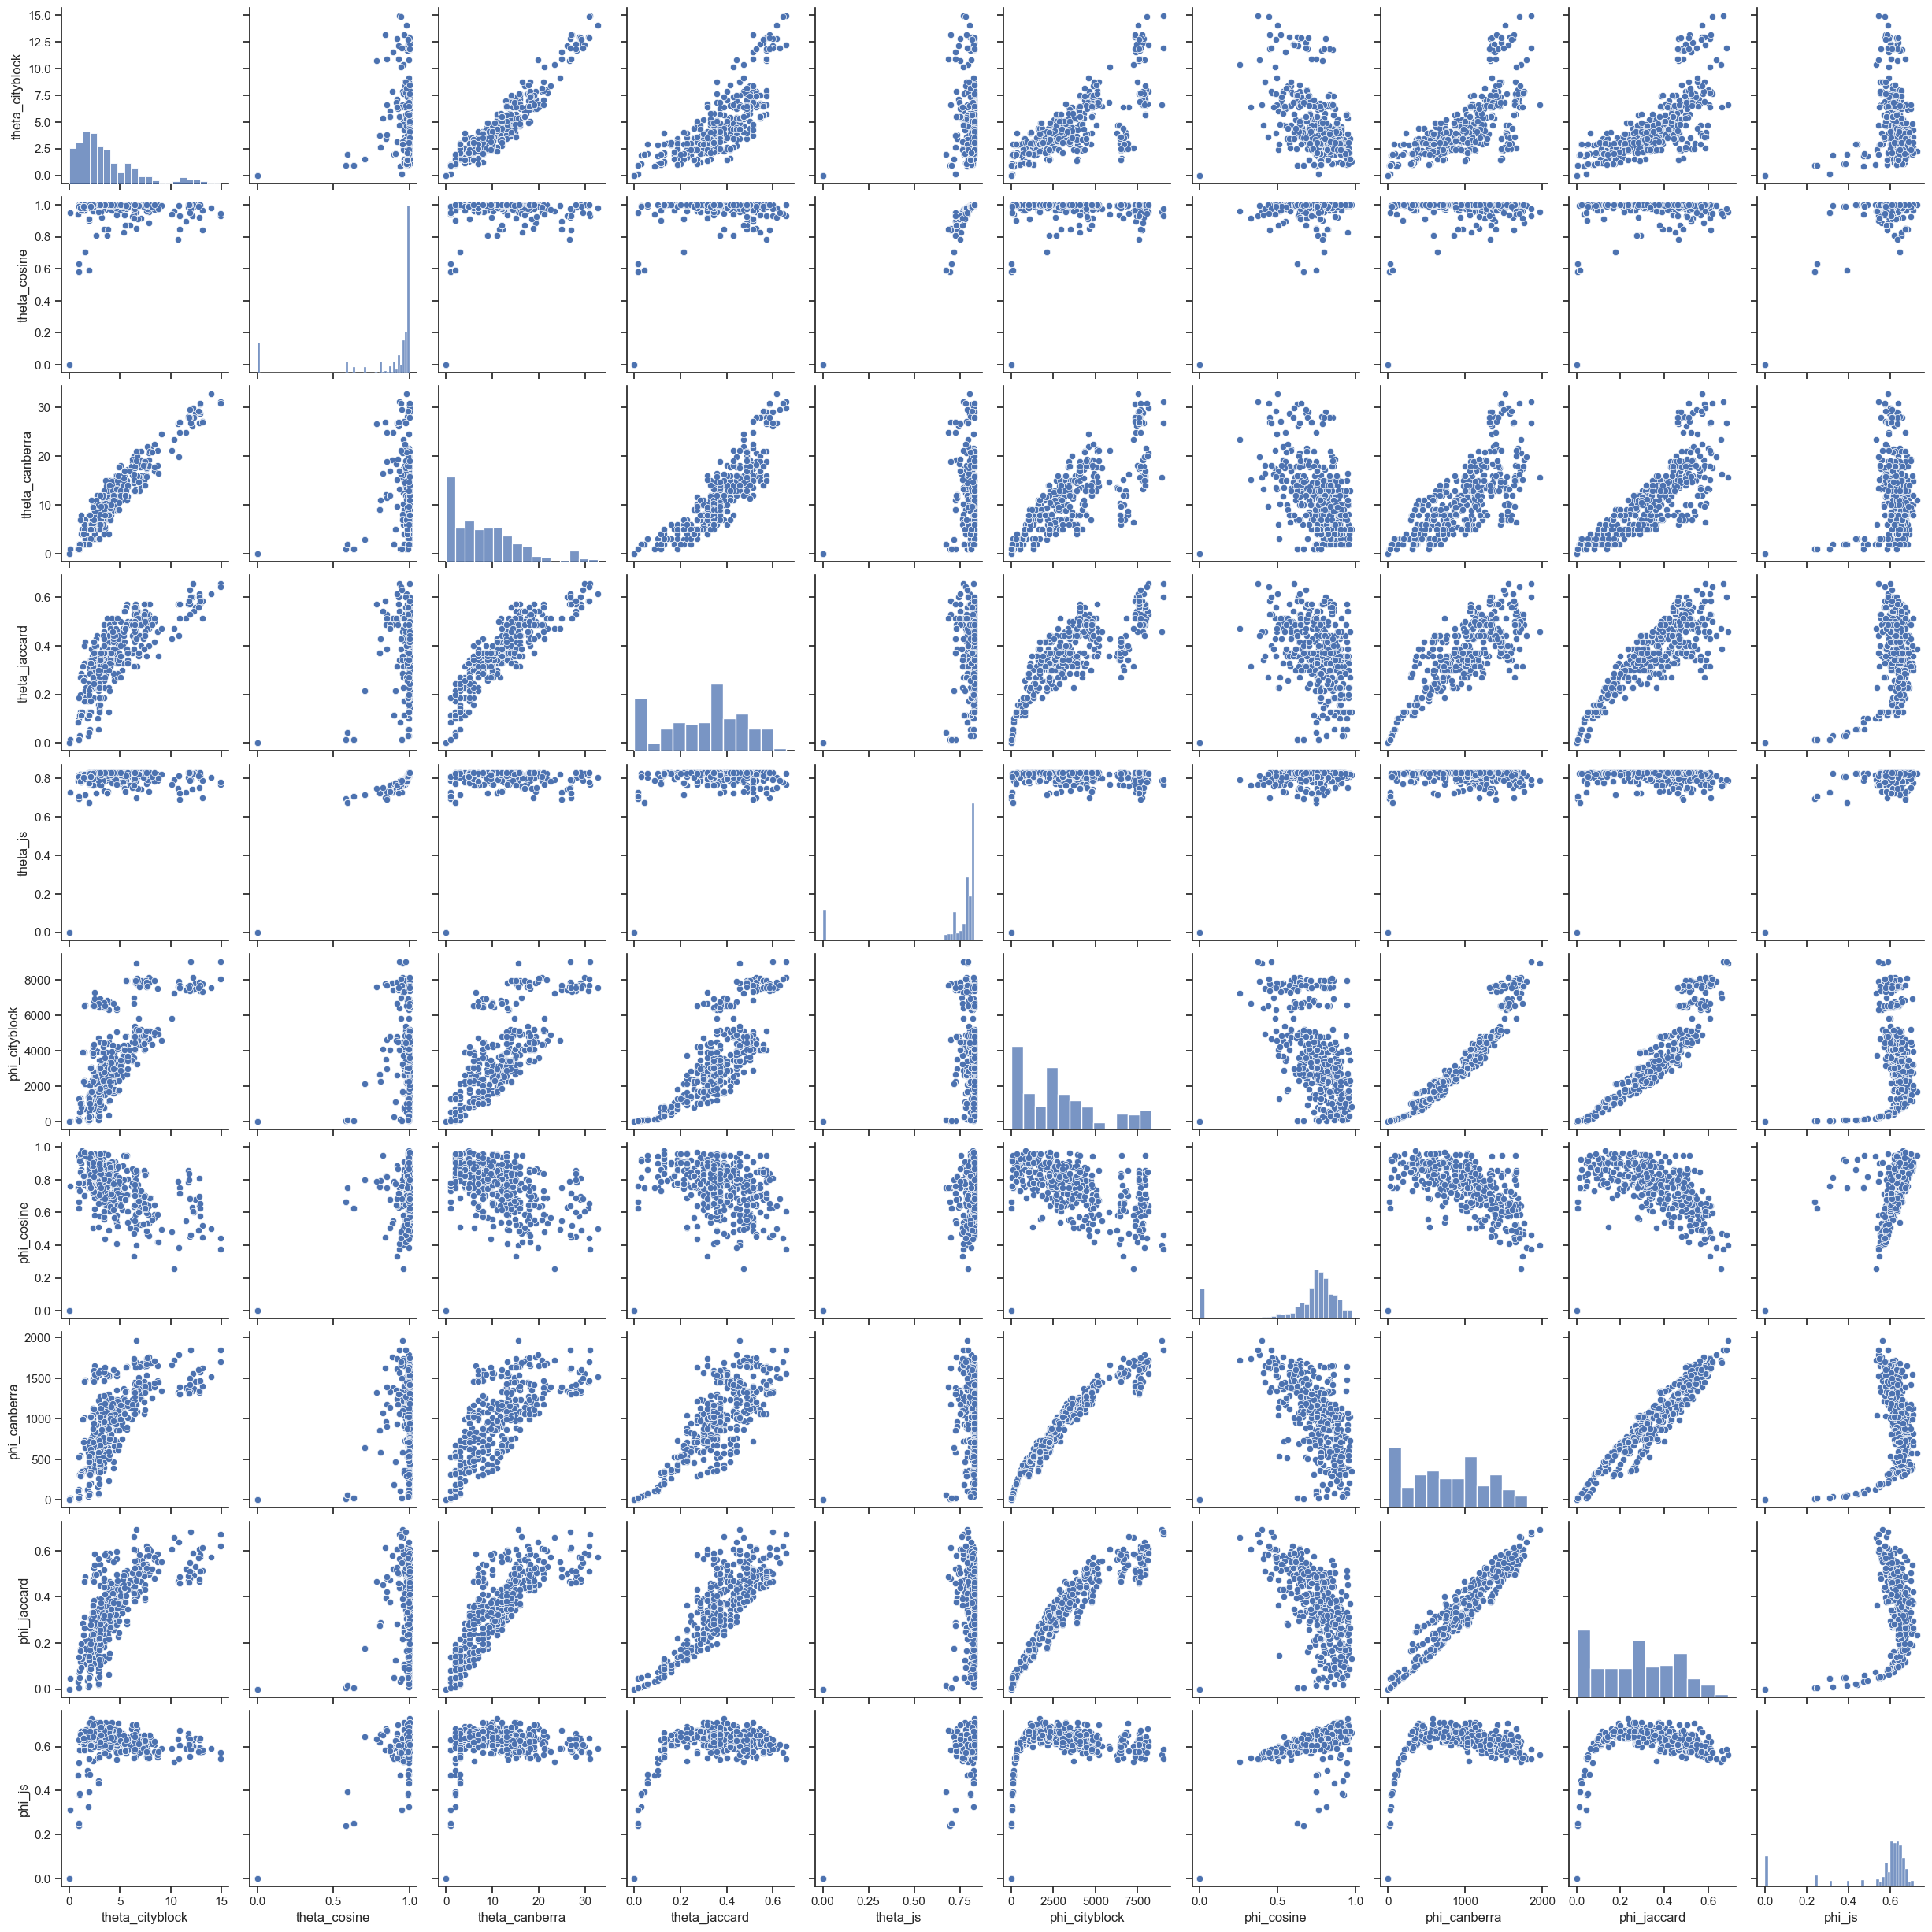

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist

tpairs_idx = [(a, b) for a, b in pd.MultiIndex.from_product([TOPICS.index, TOPICS.index]) if a < b]
TPAIRS = pd.DataFrame(tpairs_idx, columns=['topic_id_x', 'topic_id_y']).set_index(['topic_id_x', 'topic_id_y'])
TPAIRS['theta_cityblock'] = pdist(THETA.T, 'cityblock')
TPAIRS['theta_cosine'] = pdist(THETA.T, 'cosine')
TPAIRS['theta_canberra'] = pdist(THETA.T, 'canberra')
TPAIRS['theta_jaccard'] = pdist(THETA.T, 'jaccard')
TPAIRS['theta_js'] = pdist(THETA.T, 'jensenshannon')
 
TPAIRS['phi_cityblock'] = pdist(PHI, 'cityblock')
TPAIRS['phi_cosine'] = pdist(PHI, 'cosine')
TPAIRS['phi_canberra'] = pdist(PHI, 'canberra')
TPAIRS['phi_jaccard'] = pdist(PHI, 'jaccard')
TPAIRS['phi_js'] = pdist(PHI, 'jensenshannon')

sns.pairplot(TPAIRS)

In [35]:
TOPICS['doc_weight_mean'] = THETA.mean()
TOPICS.sort_values('doc_weight_mean', ascending = False)

,top_terms,doc_weight_sum,term_freq,doc_weight_mean
topic_id,,,,
T38,assistants time landlady room way teacher man ...,10.883749,0.112011,0.155482
T04,room way door time sister things hand course life,5.624936,0.117394,0.080356
T30,man time way suitcase hand hands people head eyes,5.518326,0.071388,0.078833
T22,room door way time letter servant clerk table ...,5.479734,0.060742,0.078282
T10,way woman people man judge time hand court room,3.738960,0.040320,0.053414
T08,mother father room time lift boy friend door way,3.358673,0.051268,0.047981
T21,gentleman ﬁles landlady servant way door gentl...,2.944634,0.026123,0.042066
T01,castle man landlord land public way surveyor l...,2.634840,0.034395,0.037641
T05,stoker man captain gentlemen way time ship doo...,2.524714,0.039747,0.036067


In [36]:
#TOPICS.to_csv('TOPICS.csv')

In [37]:
#THETA.to_csv('THETA.csv')

In [38]:
#PHI.to_csv('PHI.csv')

In [39]:
#DTM.to_csv('TOPICS_countmatrix.csv')

In [40]:
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','work_type']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)

In [41]:
PHI

term_str,abilities,ability,absence,absent,absolute,absolute acquittal,abuse,acceptance,access,accident,...,ﬁne,ﬁre,ﬁre brigade,ﬁrewood,ﬁrst,ﬁst,ﬁt,ﬁve,ﬁve morning,ﬂoor
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,0.025000,0.025000,0.025000,0.025000,0.025,0.025,0.025000,0.025000,0.025000,0.025000,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025
T01,0.025000,0.025000,1.003286,0.025000,0.025,0.025,0.025000,0.025000,0.025000,0.025000,...,0.025,0.025000,0.025,0.025,0.025000,0.025,2.008775,0.025,0.025,0.025
T02,1.022489,0.973224,6.038362,0.025000,0.025,0.025,0.025000,0.025000,0.025000,1.036464,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025
T03,0.025000,0.025000,0.025000,0.025000,0.025,0.025,0.025000,0.025000,0.025000,0.025000,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025
T04,1.092557,0.025000,0.025000,0.025000,0.025,0.025,4.350020,0.025000,0.025000,1.846960,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025
T05,0.025000,0.025000,0.025000,0.025000,0.025,0.025,0.025000,1.032831,0.025000,0.025000,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025
T06,0.025000,0.025000,0.025000,0.025000,0.025,0.025,0.025000,0.025000,0.025000,0.025000,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025
T07,0.025000,0.025000,2.101807,0.025000,0.025,0.025,0.025000,0.025000,0.025000,0.025000,...,0.025,8.011989,5.025,0.025,0.244376,0.025,0.025000,0.025,0.025,0.025
T08,0.025000,0.025000,3.034092,1.026881,0.025,0.025,0.025000,0.025000,0.025000,0.025000,...,0.025,0.025000,0.025,0.025,0.025000,0.025,0.025000,0.025,0.025,0.025


In [42]:
from sklearn.decomposition import PCA

# Assuming PHI is a DataFrame with index = topic_id and columns = term_str
pca_phi_engine = PCA(n_components=2)
phi_coords = pd.DataFrame(pca_phi_engine.fit_transform(PHI), 
                          index=PHI.index, columns=["PC0", "PC1"])
topic_sizes = THETA.mean(axis=0)  # Series with topic_id as index
phi_coords["mean_weight"] = phi_coords.index.map(topic_sizes)

# Get dominant topic per document
dominant_topic = THETA.idxmax(axis=1)
# Reset index if needed
dominant_topic = dominant_topic.reset_index()

# If LIB is indexed by 'book_id', make sure dominant_topic has a 'book_id' column
doc_meta = dominant_topic.join(LIB["protagonist_name"], on='book_id')

dominant_topic = dominant_topic.rename(columns={0: "topic_id"})
doc_meta = doc_meta.rename(columns = {0:"topic_id"})
# Get most common work_type for each topic
topic_label = doc_meta.groupby("topic_id")["protagonist_name"].agg(lambda x: x.mode().iloc[0])
phi_coords["work_type"] = phi_coords.index.map(topic_label)

fig = px.scatter(
    phi_coords, x="PC0", y="PC1", 
    color="work_type", 
    size="mean_weight", 
    text=phi_coords.index,
    height=700
)
fig.show()

In [43]:
LIB.index

Index([ 5200,  5252,  5353,  5454,  5555,  5656,  5757,  5858,  5959,  6060,
        6161,  6262,  6363,  6464,  6565,  6666,  6767,  6969,  7849, 23532],
      dtype='int64', name='book_id')

In [44]:
doc_meta

,book_id,chap_id,topic_id,protagonist_name
0,5200,1,T22,named
1,5200,2,T04,named
2,5200,3,T04,named
3,5252,1,T36,named
4,5353,1,T02,unnamed
...,...,...,...,...
65,23532,6,T18,unnamed
66,23532,7,T39,unnamed
67,23532,8,T30,unnamed
68,23532,9,T02,unnamed


### Creating SENTS

In [45]:
import sqlite3
import pandas as pd
import re
bing_pos_file = data_home + '/lexicons/sources/opinion-lexicon-English/positive-words.txt'
bing_neg_file = data_home + '/lexicons/sources/opinion-lexicon-English/negative-words.txt'
nrc_file = data_home + "/lexicons/sources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = data_home + "/lexicons/sources/syuzhet.csv"
gi_file = data_home + "/lexicons/sources/gi.csv"
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]
nrc['nrc_sentiment'] =nrc.nrc_positive - nrc.nrc_negative

gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']
combo = nrc.join(gi, how='outer')\
    .sort_index()
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_sentiment,gi_sentiment
term_str,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [46]:
salex = combo
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num'] # We exclude genre
CHAPS = OHCO[2:3]
PARAS = OHCO[2:4]
SENTS = OHCO[2:5]
TOKENS.set_index(['book_id']+OHCO)
TOKENS = TOKENS.join(salex, on='term_str', how='left', rsuffix="_new")
TOKENS[nrc_cols] = TOKENS[nrc_cols].fillna(0)
TOKENS[['term_str'] + nrc_cols][TOKENS['nrc_fear'] == 1.0].sample(10)

,term_str,nrc_negative,nrc_positive,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust
271281,bad,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
321216,darkness,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
373342,claw,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
410846,case,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
30781,obey,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
32061,case,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
301671,afraid,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
281706,anxiety,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
390595,ill,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
270632,case,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


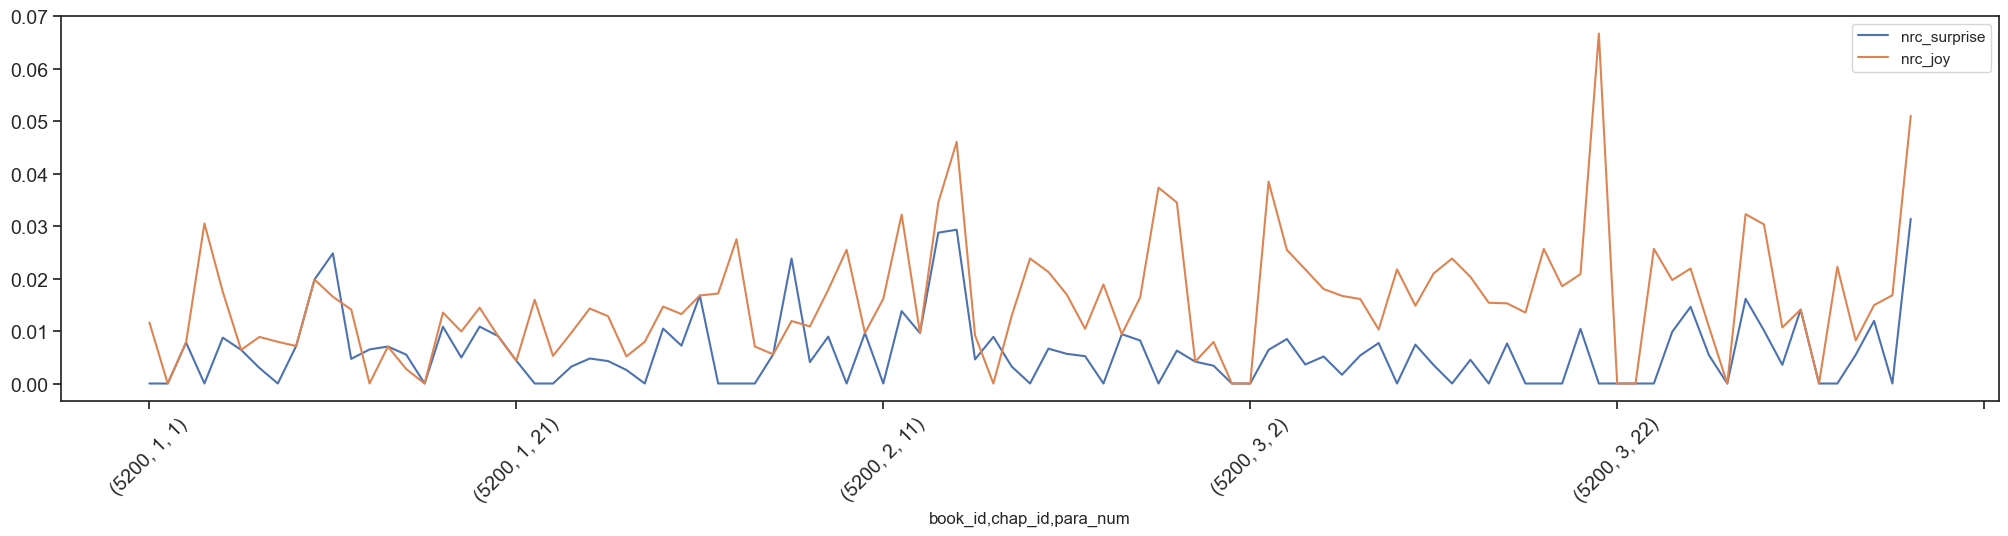

In [47]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

# This chart shows how the family was only happy once they finally got rid of gregor samsa the buggo
plot_sentiments(TOKENS[TOKENS['book_id'] == 5200].groupby(PARA)[nrc_cols].mean(), ['nrc_surprise','nrc_joy'])

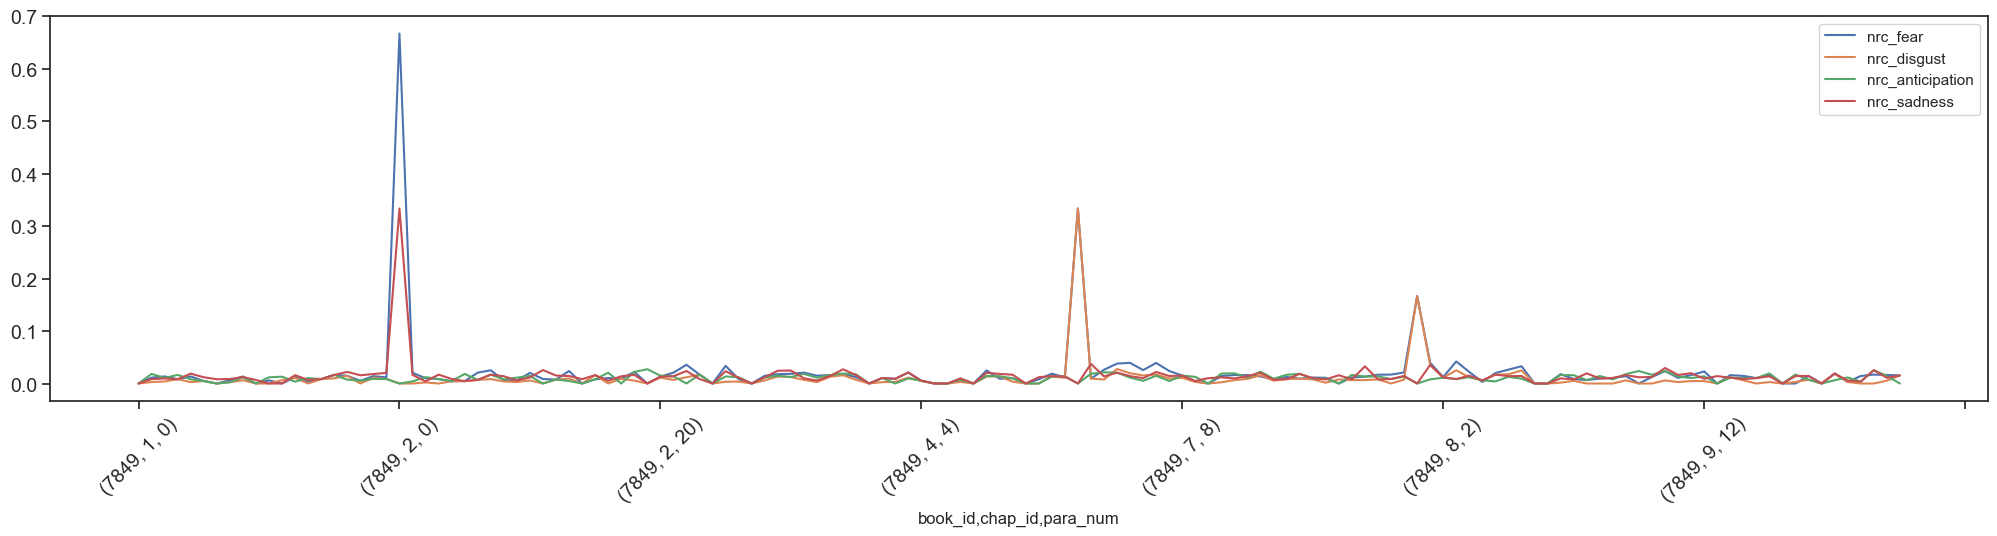

In [48]:
plot_sentiments(TOKENS[TOKENS['book_id'] == 7849].groupby(PARA)[nrc_cols].mean(), ['nrc_fear','nrc_disgust','nrc_anticipation','nrc_sadness'])

# Plot points in The trial

In [49]:
SALEX = salex.rename(columns={
    'nrc_anger': 'anger',
    'nrc_anticipation': 'anticipation',
    'nrc_disgust': 'disgust',
    'nrc_fear': 'fear',
    'nrc_joy': 'joy',
    'nrc_negative': 'negative',
    'nrc_positive': 'positive',
    'nrc_sadness': 'sadness',
    'nrc_surprise': 'surprise',
    'nrc_trust': 'trust',
    'nrc_sentiment': 'nrc_sentiment',
    'gi_sentiment': 'gi_sentiment'
})

CORPUS = tokenize_collection(LIB)
CORPUS = CORPUS[CORPUS.term_str != '']
CORPUS['pos_group'] = CORPUS.pos.str[:2]

VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)


V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
V.head()

Tokenizing 5200 METAMORPHOSIS
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5200.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[IVXLCM]+\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5252 BLUMFELD
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5252.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5353 THE BURROW
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5353.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
li

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,...,disgust,fear,joy,negative,positive,sadness,surprise,trust,nrc_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandon,6,7,0.000014,16.105653,VB,VB,2,"{JJ, VB}",3,"{VBP, JJ, VB}",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,-1.0
abandoned,21,9,0.000050,14.298298,VBN,VB,4,"{RP, NN, JJ, VB}",5,"{NN, VBN, VBD, JJ, RP}",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN
abduction,1,9,0.000002,18.690615,NN,NN,1,{NN},1,{NN},...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,NaN
abhorrent,2,9,0.000005,17.690615,JJ,JJ,1,{JJ},1,{JJ},...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,NaN
ability,10,7,0.000024,15.368687,NN,NN,1,{NN},1,{NN},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [54]:
BOWofCORPUS = BOW(CORPUS,'CHAPS')
BOWofCORPUS
TFIDF_reset = TFIDF.reset_index()
TFIDF_long = TFIDF_reset.melt(
    id_vars = ['book_id','chap_id'],
    var_name = 'term_str',
    value_name = 'tfidf'
)
BOWofCORPUSwithTFIDF = BOWofCORPUS.reset_index().merge(TFIDF_long, on=['book_id', 'chap_id', 'term_str'], how='left')
BOWofCORPUSwithTFIDF
emo_cols = "anger anticipation disgust fear joy sadness surprise trust gi_sentiment nrc_sentiment".split()
B = BOWofCORPUSwithTFIDF.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna().set_index(['book_id','chap_id','term_str'])
B

n     tfidf max_pos  anger  anticipation  disgust  \
book_id chap_id term_str                                                        
5200    1       afraid      2  0.004791      JJ    0.0           0.0      0.0   
                alarm       3  0.014120      NN    0.0           0.0      0.0   
                anger       1  0.006047      NN    1.0           0.0      0.0   
                anxious     1  0.004899      JJ    0.0           1.0      0.0   
                attack      1  0.005317      NN    1.0           0.0      0.0   
...                        ..       ...     ...    ...           ...      ...   
23532   10      unbearable  1  0.038627      JJ    0.0           0.0      1.0   
                upright     1  0.017957      JJ    0.0           0.0      0.0   
                wild        1  0.020197      JJ    0.0           0.0      0.0   
                wisdom      1  0.041213      NN    0.0           0.0      0.0   
                worry       1  0.025842      VB    0.0           1.0      0.0   

                            fear  joy  sadness  surprise  trust  gi_sentiment  \
book_id chap_id term_str                                                        
5200    1       afraid       1.0  0.0      0.0       0.0    0.0          -1.0   
                alarm        1.0  0.0      0.0       1.0    0.0          -1.0   
                anger        0.0  0.0      0.0       0.0    0.0          -1.0   
                anxious      1.0  0.0      0.0       0.0    0.0          -1.0   
                attack       1.0  0.0      0.0       0.0    0.0          -1.0   
...                          ...  ...      ...       ...    ...           ...   
23532   10      unbearable   0.0  0.0      1.0       0.0    0.0          -1.0   
                upright      0.0  0.0      0.0       0.0    1.0           1.0   
                wild         0.0  0.0      0.0       1.0    0.0          -1.0   
                wisdom       0.0  0.0      0.0       0.0    1.0           1.0   
                worry        1.0  0.0      1.0       0.0    0.0          -1.0   

                            nrc_sentiment  
book_id chap_id term_str                   
5200    1       afraid               -1.0  
                alarm                -1.0  
                anger                -1.0  
                anxious              -1.0  
                attack               -1.0  
...                                   ...  
23532   10      unbearable           -1.0  
                upright               1.0  
                wild                 -1.0  
                wisdom                1.0  
                worry                -1.0  

[5494 rows x 13 columns]

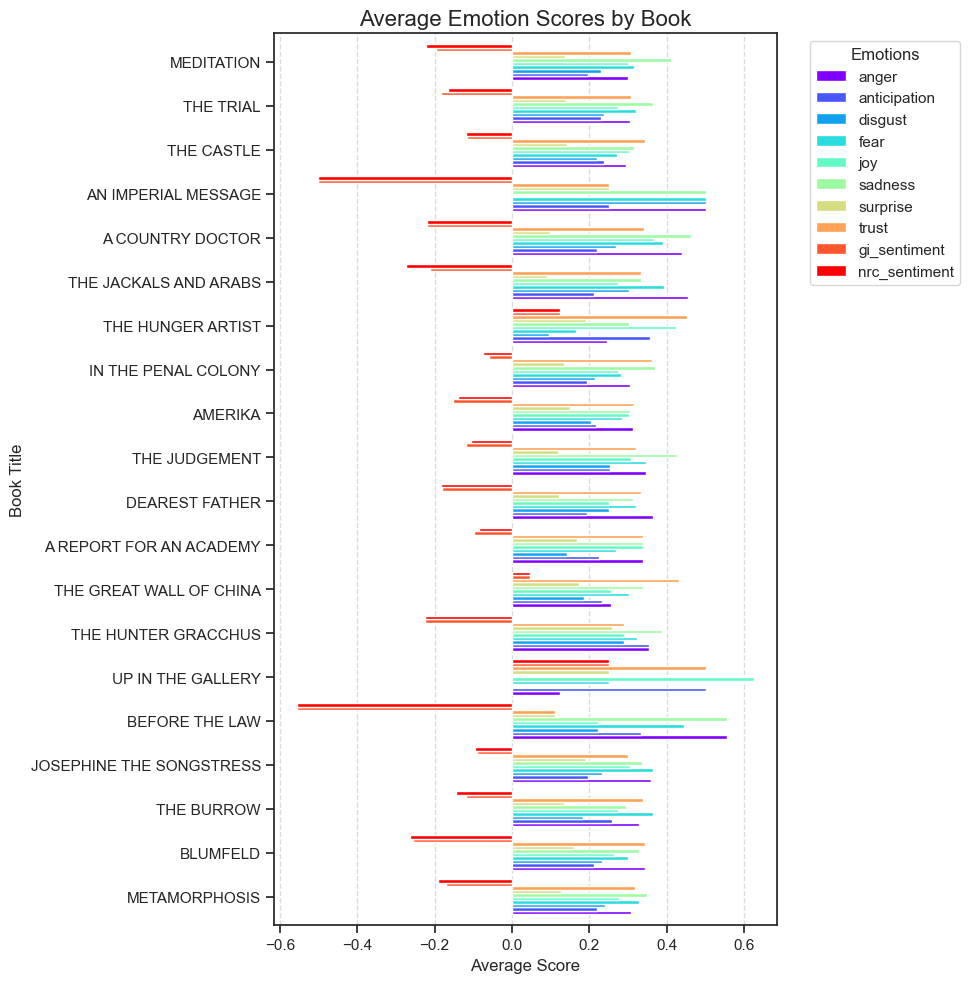

In [55]:
import matplotlib.pyplot as plt

# Group and plot
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_BOOKS.index = LIB.title  # Replace book_id with readable titles

# Plotting
ax = EMO_BOOKS.plot.barh(
    figsize=(10, 10),
    width=0.8,               # Adjust bar thickness
    colormap='rainbow',      # Optional: use a more vibrant colormap
)

# Layout & Style Tweaks
plt.title("Average Emotion Scores by Book", fontsize=16)
plt.xlabel("Average Score", fontsize=12)
plt.ylabel("Book Title", fontsize=12)

plt.legend(title="Emotions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjusts padding to avoid clipping labels

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: gridlines for readability

plt.show()

In [59]:
OHCO = ['book_id', 'sent_num', 'token_num']
# PARA = OHCO[:4] # Paragraphs
# SENT = OHCO[:5] # Sentences
BAG = OHCO[:1]
# BAG = SENT

# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)
import gensim
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px
docs = TOKENS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs
vocab = Dictionary(docs)
model = word2vec.Word2Vec(docs, **w2v_params)
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
a,-0.102380,-0.050363,0.180050,0.019744,0.001759,-0.162391,0.085503,0.213102,-0.223246,-0.017918,...,0.042282,0.076577,0.026454,-0.072863,0.011192,-0.145087,0.000496,0.108044,-0.097369,-0.170874
able,0.048226,0.075320,-0.026472,0.092003,0.256959,-0.276404,0.008785,0.251488,-0.133465,0.043420,...,0.007864,-0.062605,-0.191458,-0.146155,-0.059364,-0.033009,0.015167,-0.035787,0.015496,-0.182485
about,0.075716,-0.014233,-0.046716,0.080880,0.173334,-0.237008,0.050265,0.321524,-0.178008,0.038617,...,-0.025355,-0.052452,-0.134929,-0.103344,-0.032009,-0.109128,-0.017117,-0.018210,0.009928,-0.184386
above,-0.011032,-0.009074,0.032606,0.026247,0.084284,-0.186447,0.055383,0.292708,-0.208649,0.012690,...,0.012177,-0.008322,-0.045979,-0.063750,0.002453,-0.129073,-0.008648,0.022436,-0.065356,-0.193279
account,-0.001612,-0.006982,0.016862,0.018199,0.059941,-0.130442,0.024406,0.185815,-0.129902,0.005396,...,0.012714,-0.003186,-0.033143,-0.041029,0.000849,-0.082679,-0.002290,0.011821,-0.036037,-0.126250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yourself,0.014583,0.011224,0.028924,0.049303,0.143931,-0.233406,0.035379,0.273817,-0.177150,0.023154,...,0.014665,-0.026357,-0.098749,-0.105166,-0.027242,-0.103296,0.007288,0.000263,-0.026489,-0.183622
youve,0.002809,0.002779,0.010372,0.030105,0.089447,-0.166018,0.028684,0.203937,-0.130462,0.016017,...,0.006125,-0.015776,-0.062158,-0.063357,-0.014565,-0.072609,-0.008117,0.001967,-0.021263,-0.134753
ﬁles,-0.004668,-0.000373,0.004226,0.003450,0.001236,0.003547,-0.003530,0.001551,-0.003025,0.000323,...,0.003475,0.004883,0.001396,-0.003070,0.000767,-0.000409,-0.003891,-0.003099,-0.002745,0.000530


In [ ]:
#WV.to_csv('VOCAB_W2V.csv')

In [66]:
V
#V.to_csv('VOCAB_SENT.csv')

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,...,disgust,fear,joy,negative,positive,sadness,surprise,trust,nrc_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandon,6,7,0.000014,16.105653,VB,VB,2,"{JJ, VB}",3,"{VBP, JJ, VB}",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,-1.0
abandoned,21,9,0.000050,14.298298,VBN,VB,4,"{RP, NN, JJ, VB}",5,"{NN, VBN, VBD, JJ, RP}",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN
abduction,1,9,0.000002,18.690615,NN,NN,1,{NN},1,{NN},...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,NaN
abhorrent,2,9,0.000005,17.690615,JJ,JJ,1,{JJ},1,{JJ},...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,NaN
ability,10,7,0.000024,15.368687,NN,NN,1,{NN},1,{NN},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young,152,5,0.000359,11.442688,JJ,JJ,4,"{NN, JJ, RB, VB}",5,"{RB, VB, NN, JJ, NNP}",...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN
youth,24,5,0.000057,14.105653,NN,NN,1,{NN},1,{NN},...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN
zeal,5,4,0.000012,16.368687,NN,NN,1,{NN},1,{NN},...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN


In [69]:
B
#B.to_csv('BOW_SENT.csv')

n     tfidf max_pos  anger  anticipation  disgust  \
book_id chap_id term_str                                                        
5200    1       afraid      2  0.004791      JJ    0.0           0.0      0.0   
                alarm       3  0.014120      NN    0.0           0.0      0.0   
                anger       1  0.006047      NN    1.0           0.0      0.0   
                anxious     1  0.004899      JJ    0.0           1.0      0.0   
                attack      1  0.005317      NN    1.0           0.0      0.0   
...                        ..       ...     ...    ...           ...      ...   
23532   10      unbearable  1  0.038627      JJ    0.0           0.0      1.0   
                upright     1  0.017957      JJ    0.0           0.0      0.0   
                wild        1  0.020197      JJ    0.0           0.0      0.0   
                wisdom      1  0.041213      NN    0.0           0.0      0.0   
                worry       1  0.025842      VB    0.0           1.0      0.0   

                            fear  joy  sadness  surprise  trust  gi_sentiment  \
book_id chap_id term_str                                                        
5200    1       afraid       1.0  0.0      0.0       0.0    0.0          -1.0   
                alarm        1.0  0.0      0.0       1.0    0.0          -1.0   
                anger        0.0  0.0      0.0       0.0    0.0          -1.0   
                anxious      1.0  0.0      0.0       0.0    0.0          -1.0   
                attack       1.0  0.0      0.0       0.0    0.0          -1.0   
...                          ...  ...      ...       ...    ...           ...   
23532   10      unbearable   0.0  0.0      1.0       0.0    0.0          -1.0   
                upright      0.0  0.0      0.0       0.0    1.0           1.0   
                wild         0.0  0.0      0.0       1.0    0.0          -1.0   
                wisdom       0.0  0.0      0.0       0.0    1.0           1.0   
                worry        1.0  0.0      1.0       0.0    0.0          -1.0   

                            nrc_sentiment  
book_id chap_id term_str                   
5200    1       afraid               -1.0  
                alarm                -1.0  
                anger                -1.0  
                anxious              -1.0  
                attack               -1.0  
...                                   ...  
23532   10      unbearable           -1.0  
                upright               1.0  
                wild                 -1.0  
                wisdom                1.0  
                worry                -1.0  

[5494 rows x 13 columns]

In [72]:
EMO_BOOKS
#EMO_BOOKS.to_csv('DOC_SENT.csv')

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,gi_sentiment,nrc_sentiment
title,,,,,,,,,,
METAMORPHOSIS,0.307692,0.220280,0.241259,0.328671,0.276224,0.349650,0.125874,0.318182,-0.171329,-0.192308
BLUMFELD,0.343066,0.211679,0.233577,0.299270,0.262774,0.328467,0.160584,0.343066,-0.255474,-0.262774
THE BURROW,0.328358,0.258706,0.184080,0.363184,0.273632,0.293532,0.134328,0.338308,-0.119403,-0.144279
JOSEPHINE THE SONGSTRESS,0.359281,0.197605,0.233533,0.365269,0.305389,0.335329,0.191617,0.299401,-0.089820,-0.095808
BEFORE THE LAW,0.555556,0.333333,0.222222,0.444444,0.222222,0.555556,0.111111,0.111111,-0.555556,-0.555556
UP IN THE GALLERY,0.125000,0.500000,0.000000,0.250000,0.625000,0.000000,0.250000,0.500000,0.250000,0.250000
THE HUNTER GRACCHUS,0.354839,0.354839,0.290323,0.322581,0.290323,0.387097,0.258065,0.290323,-0.225806,-0.225806
THE GREAT WALL OF CHINA,0.255814,0.232558,0.186047,0.302326,0.255814,0.337209,0.174419,0.430233,0.046512,0.046512
A REPORT FOR AN ACADEMY,0.338028,0.225352,0.140845,0.267606,0.338028,0.338028,0.169014,0.338028,-0.098592,-0.084507
